## Modelo de Predicción de KARBE Ingenio Pánuco

El presente modelo se puede utilizar para realizar predicciones sobre el valor de KARBE/TCN en función del DIA DE ZAFRA.

Se selecciona dependencia sobre el DIA DE ZAFRA y no sobre la FECHA para aislar variaciones provenientes de la calidad de caña, programas de madurante, programas de cosecha, etc., que se ajustan para el arranque de zafra.

### Selección de Modelo
Se seleccionó un **Proceso Gaussiano** no-paramétrico para encontrar una familia de funciones para aproximar el valor del *KARBE* en función de los días de zafra. Esto pues, a diferencia de una Serie de Tiempo, ayuda a aprovechar la periodicidad del comportamiento del KARBE entre zafras, y adicionalmente a interpolar cualquier DIA DE ZAFRA.

Para este modelo no-paramétrico se realizó una regresión de proceso Gaussiano sobre distintas zafras, utilizando un Kernel RBF para observaciones "ruidosas" (RBF + WK). El modelo se entrena con el conjunto completo de observaciones.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK

%matplotlib inline

In [2]:
# Function to show the summary of the fit
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n\n%s" % gp.kernel_
    s2 = "\n\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    print(s1 + s2 + '\n')

### Dataset KARBE
Este dataset contiene información diaria del KARBE/TCB y KARBE/TCN para las Zafras **19-20, 20-21, 21-22 y 22-23**. 

El **KARBE** se refiere a los *Kilogramos de Azúcar Recuperables Base Estándar* que se obtienen de un peso de caña especificado.
- KARBE/TCB contiene información del KARBE sobre Toneladas de Caña en Peso Bruto (Total).
- KARBE/TCN contiene información del KARBE sobre Toneladas de Caña en Peso NETO (Total - Trash).

*Los valores de KARBE/TCN son siempre mayores a los de KARBE/TCB pues en general el peso TCN es menor que el peso TCB.*

In [3]:
df_all = pd.read_csv(r'C:\Users\sbarrios\OneDrive - Universidad Galileo\Data Science\Python\Proyectos\Pruebas\Pantaleon\Karbe\Karbe_Panuco.csv')
df_all

,Zafra,Dia Zafra,Fecha,KARBE/TCB,KARBE/TCN
0,2020,1,2-Dec-19,86.59,91.53
1,2020,2,3-Dec-19,92.57,98.65
2,2020,3,4-Dec-19,93.31,100.20
3,2020,4,5-Dec-19,88.10,93.83
4,2020,5,6-Dec-19,96.96,103.75
...,...,...,...,...,...
685,2023,90,17-Oct-21,117.01,124.55
686,2023,91,18-Oct-21,119.78,127.50
687,2023,92,19-Oct-21,112.63,120.55
688,2023,93,20-Oct-21,113.69,121.08


### Entrenamiento Proceso Gaussiano KARBE/TCN

Para el entrenamiento se utilizan valores de la zafra (o zafras) específicas del análisis, descartando los valores nulos.
La métrica a optimizar es la Log-Likelihood del modelo (maximización). El resultado es un modelo probabilístico con Kernel RBF + WK

### Pronósticos KARBE/TCN
El pronóstico consiste en la aplicación del modelo para un rango de DIAS DE ZAFRA especificado. 

El resultado de la predicción es una **distribución de probabilidad condicional del KARBE basado en el DIA DE ZAFRA**. Esto nos permite no solo dar un valor puntual para la predicción (condicionado a cualquier día de zafra) sino también la construcción de intervalos de confianza, de forma que pueda calcularse *la probabilidad de que la predicción se encuentre dentro de este intervalo con el nivel de confianza que se requiera*.

Esto es particularmente útil cuando se requieren construir escenarios, donde el **nivel de confianza** es una métrica aún más informativa que los típicos escenarios **optimistas / realistas / pesimistas**.

Para cada predicción se muestra:
- El valor esperado de la distribución condicional (valor pronosticado).
- La desviación estándar de la predicción (para construcción de intervalos de confianza bajo un modelo Gaussiano o Normal).
- Muestreo de funciones en la distribución de familia de funciones encontrada (escenarios simulados):


### KARBE/TCN Año 2020
#### Entrenamiento

In [4]:
# Specify observations
df_2020 = df_all[df_all['Zafra'] == 2020]
df_2020 = df_2020.drop(df_all[df_all['KARBE/TCB'] == 0].index)
y = df_2020['KARBE/TCN'].values
X = np.array(df_2020['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 1e2)) + WK(10)
gp_2020 = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_2020.fit(X, y)
summary(gp_2020)

Fitted Kernel(Optimized)

74.2**2 * RBF(length_scale=67.4) + WhiteKernel(noise_level=28.2)

log marginal likelihood: -542.12256



#### Predicción

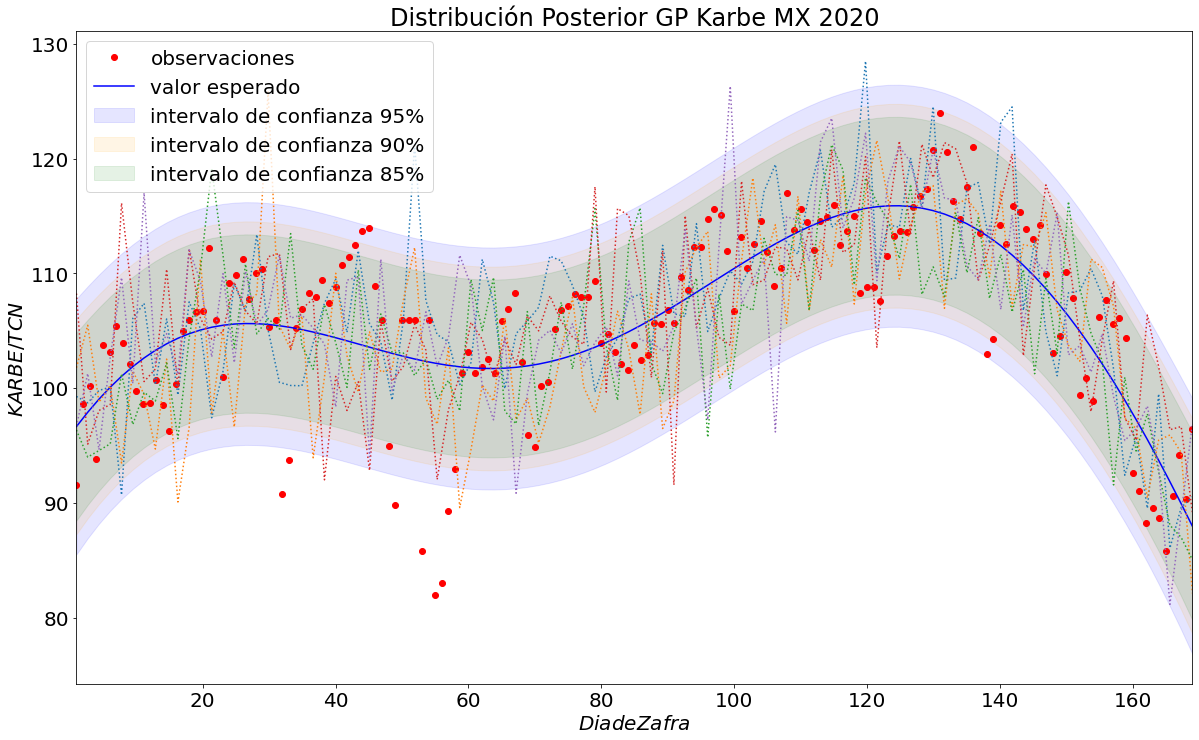

In [5]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 169, 100), ndmin = 2).T
f_mean, f_var = gp_2020.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X, y, 'ro', label='observaciones')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 169, 100), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_2020.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
#plt.ylim(70, 130)
plt.legend(loc='upper left')
plt.title('Distribución Posterior GP Karbe MX 2020')
plt.show()


### KARBE Año 2021

In [6]:
# Specify observations
df_2021 = df_all[df_all['Zafra'] == 2021]
df_2021 = df_2021.drop(df_all[df_all['KARBE/TCB'] == 0].index)
y = df_2021['KARBE/TCN'].values
X = np.array(df_2021['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 1e2)) + WK(10)
gp_2021 = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_2021.fit(X, y)
summary(gp_2021)

Fitted Kernel(Optimized)

91.5**2 * RBF(length_scale=43.6) + WhiteKernel(noise_level=14.7)

log marginal likelihood: -547.76384



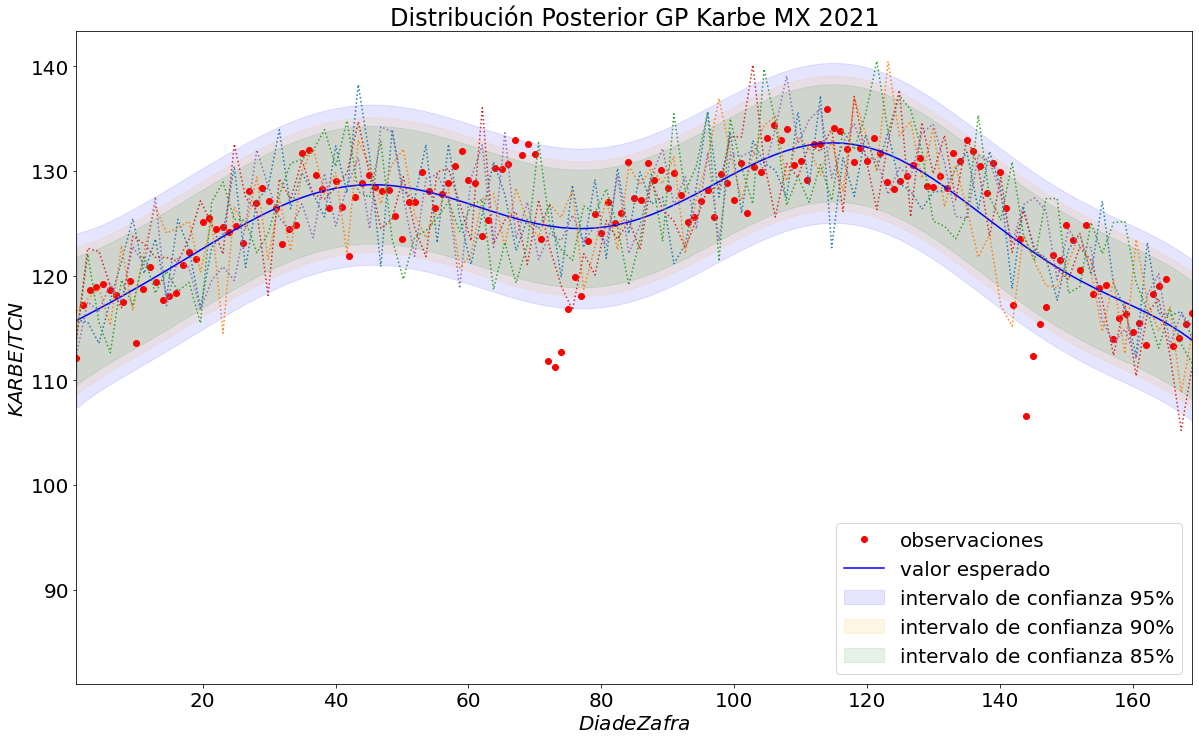

In [7]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 169, 100), ndmin = 2).T
f_mean, f_var = gp_2021.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X, y, 'ro', label='observaciones')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')


# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 169, 100), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_2021.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
#plt.ylim(70, 150)
plt.legend(loc='lower right')
plt.title('Distribución Posterior GP Karbe MX 2021')
plt.show()

### KARBE ALL YEARS

In [8]:
# Specify observations
df_todos = df_all
#df_todos = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022) | (df_all['Zafra'] == 2021)]
#df_todos = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022)]

df_todos = df_todos.drop(df_todos[df_todos['KARBE/TCB'] == 0].index)
y = df_todos['KARBE/TCN'].values
X = np.array(df_todos['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 1e2)) + WK(1)
gp_todos = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_todos.fit(X, y)
summary(gp_todos)

Fitted Kernel(Optimized)

107**2 * RBF(length_scale=53.2) + WhiteKernel(noise_level=126)

log marginal likelihood: -2677.51382



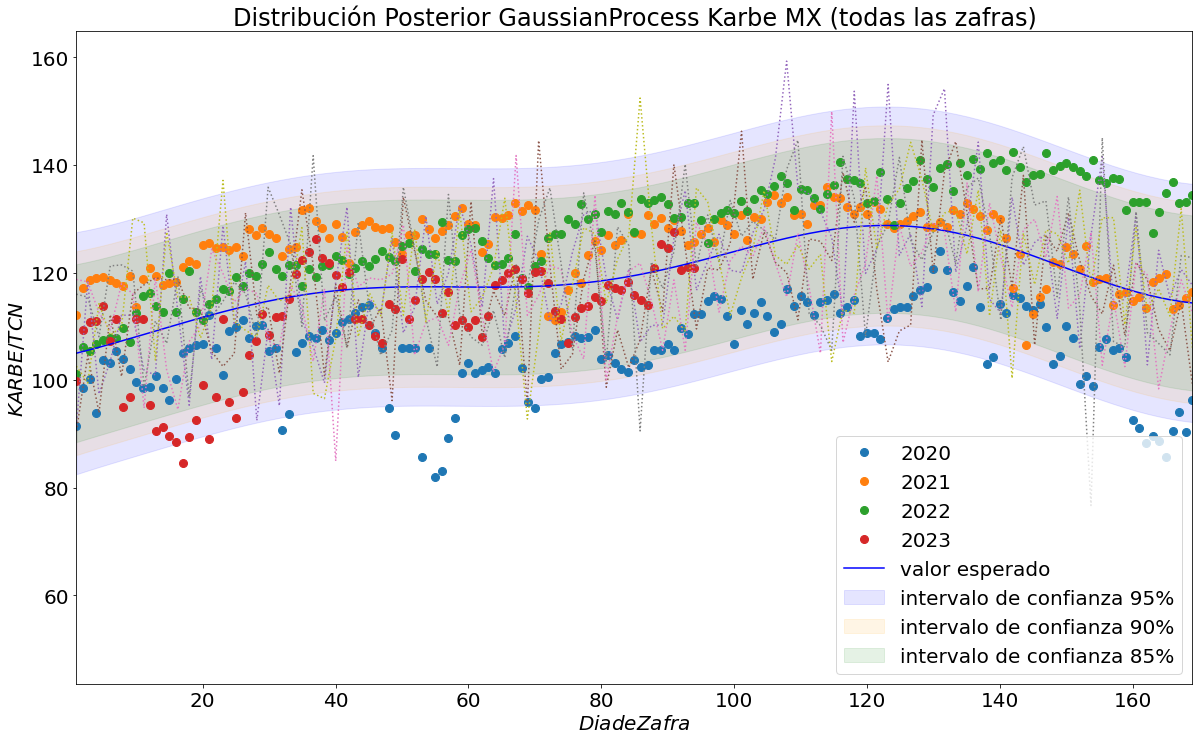

In [9]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 169, 100), ndmin = 2).T
f_mean, f_var = gp_todos.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
X_plot = df_todos['Dia Zafra']
y_plot = df_todos['KARBE/TCN']
labels = df_todos['Zafra']
df_plot = pd.DataFrame(dict(x=X_plot, y=y_plot, label=labels))
groups = df_plot.groupby('label')

# Plot
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=8, label=name)

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 169, 100), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_todos.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
plt.legend(loc='lower right')
plt.title('Distribución Posterior GaussianProcess Karbe MX (todas las zafras)')
plt.show()

Basándonos en las tendencias de los valores de KARBE/TCN, podemos distinguir que la zafra **2019-2020** muestra valores consistentemente más bajos respecto a las zafras posteriores. Esto requiere mayor investigación, con el objetivo de determinar si es un comportamiento que pueda repetirse en el futuro. Ante esta incertidumbre, se decide excluir del análisis la zafra 2019-2020, entrenando un modelo final con las últimas tres zafras (incluyendo la zafra actual 2022-2023).

### KARBE Final

In [10]:
# Specify observations
df_final = df_all[(df_all['Zafra'] == 2023) | (df_all['Zafra'] == 2022) | (df_all['Zafra'] == 2021)]

df_final = df_final.drop(df_final[df_final['KARBE/TCB'] == 0].index)
y = df_final['KARBE/TCN'].values
X = np.array(df_final['Dia Zafra'].values, ndmin=2).T

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 1e2)) + WK(1)
gp_final = GPR(kernel=kernel, alpha = 0.75, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp_final.fit(X, y)
summary(gp_final)
gp_final.score(X, y)

Fitted Kernel(Optimized)

90.1**2 * RBF(length_scale=38.4) + WhiteKernel(noise_level=69.9)

log marginal likelihood: -1883.49216



0.6340236856444171

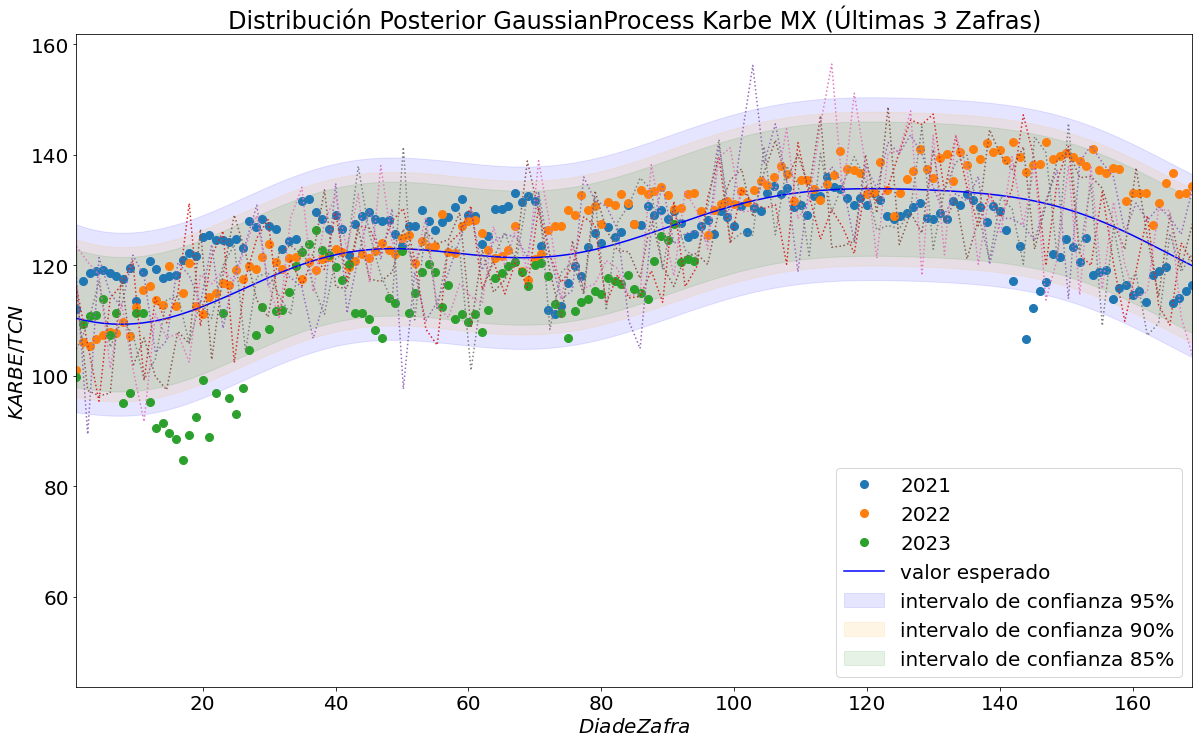

In [11]:
# Make a prediction on several test points
X_test = np.array(np.linspace(1, 169, 169), ndmin = 2).T
f_mean, f_var = gp_final.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
X_plot = df_final['Dia Zafra']
y_plot = df_final['KARBE/TCN']
labels = df_final['Zafra']
df_plot = pd.DataFrame(dict(x=X_plot, y=y_plot, label=labels))
groups = df_plot.groupby('label')

# Plot
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=8, label=name)

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='valor esperado')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='intervalo de confianza 95%')

# Draw a mean function and 90% confidence interval
upper_bound = f_mean + 1.65 * f_var
lower_bound = f_mean - 1.65 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'orange', alpha = 0.1,
                 label='intervalo de confianza 90%')

# Draw a mean function and 85% confidence interval
upper_bound = f_mean + 1.44 * f_var
lower_bound = f_mean - 1.44 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'g', alpha = 0.1,
                 label='intervalo de confianza 85%')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(1, 169, 100), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp_final.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$Dia de Zafra$')
plt.ylabel('$KARBE/TCN$')
plt.xlim(X_test.min(), X_test.max())
plt.legend(loc='lower right')
plt.title('Distribución Posterior GaussianProcess Karbe MX (Últimas 3 Zafras)')
plt.show()

Finalmente, se exporta el resultado de los pronósticos por día de zafra a un archivo CSV de salida.

In [12]:
# Generate Data
data = {'Dia Zafra': np.arange(1,170),
        'Pronóstico': f_mean,
        'Desviación Estándar': f_var,
        'LI_95:': f_mean - 1.96*f_var,
        'UI_95:': f_mean + 1.96*f_var,
        'LI_90:': f_mean - 1.65*f_var,
        'UI_90:': f_mean + 1.65*f_var,
        'LI_85:': f_mean - 1.44*f_var,
        'UI_85:': f_mean + 1.44*f_var
       }

# Create DataFrame
df_salida = pd.DataFrame(data)
df_salida

,Dia Zafra,Pronóstico,Desviación Estándar,LI_95:,UI_95:,LI_90:,UI_90:,LI_85:,UI_85:
0,1,110.401533,8.683924,93.381041,127.422025,96.073058,124.730009,97.896682,122.906384
1,2,110.118008,8.610322,93.241777,126.994238,95.910977,124.325038,97.719144,122.516871
2,3,109.876162,8.555116,93.108135,126.644189,95.760221,123.992103,97.556796,122.195529
3,4,109.677886,8.514761,92.988955,126.366818,95.628531,123.727242,97.416631,121.939142
4,5,109.524705,8.486134,92.891881,126.157529,95.522583,123.526827,97.304671,121.744739
...,...,...,...,...,...,...,...,...,...
164,165,122.386633,8.441962,105.840387,138.932879,108.457395,136.315871,110.230207,134.543059
165,166,121.763135,8.442131,105.216557,138.309712,107.833618,135.692651,109.606465,133.919804
166,167,121.142006,8.442336,104.595028,137.688984,107.212152,135.071860,108.985042,133.298970
167,168,120.526736,8.442585,103.979269,137.074203,106.596470,134.457002,108.369413,132.684059


In [13]:
# Print the output.
df_salida.to_csv(r'C:\Users\sbarrios\OneDrive - Universidad Galileo\Data Science\Python\Proyectos\Pruebas\Pantaleon\Karbe\Prediccion_Karbe_Panuco.csv')